In [9]:
!pip install keras

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

In [12]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/CICDataset/cicddos2019_dataset.csv')


data = data.drop(columns=['Flow ID', 'Source IP', 'Destination IP', 'Timestamp', 'Label'], errors='ignore')

# data["Class"]
# Label Encoding: Convert BENIGN and DDoS into binary labels (0 for BENIGN, 1 for DDoS)
labels = (data['Class'] != 'Benign').astype(int)  # DDoS = 1, BENIGN = 0

data["Labels"] = labels

# Drop the Label column after encoding
data = data.drop(columns=['Class'], errors='ignore')


# Handle missing values by replacing them with zeros
data.fillna(0, inplace=True)

# remove columns with 0 variance
selector = VarianceThreshold(threshold=0)
data_var = selector.fit_transform(data)
data = pd.DataFrame(data_var, columns=data.columns[selector.get_support(indices=True)])
print(data.var())

# Normalize the dataset using MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Split the data into normal (BENIGN) and DDoS attack data
X_normal = data_scaled[labels == 0]
X_ddos = data_scaled[labels == 1]

# Train-test split (Train the model only on normal traffic data)
X_train, X_test = train_test_split(X_normal, test_size=0.2, random_state=42)


Unnamed: 0                7.612495e+09
Protocol                  2.466823e+01
Flow Duration             4.522411e+14
Total Fwd Packets         3.837246e+04
Total Backward Packets    3.177600e+03
                              ...     
Idle Mean                 6.263155e+13
Idle Std                  4.020685e+12
Idle Max                  8.181794e+13
Idle Min                  5.249815e+13
Labels                    1.753572e-01
Length: 67, dtype: float64


In [13]:
'''
input_dim: This determines the number of features in the input data (X_train). The autoencoder will take data with this number of features as input.
encoding_dim: This is the size of the first encoded layer, which will compress the input data into a lower-dimensional representation.

'''
input_dim = X_train.shape[1]
encoding_dim = 16


'''
autoencoder.add(Dense(encoding_dim, activation="relu", input_shape=(input_dim,))):
    This is the first layer, which maps the input to the compressed layer.
    It has encoding_dim neurons (16 in this case) and uses the ReLU activation function to introduce non-linearity.

autoencoder.add(Dense(int(encoding_dim / 2), activation="relu")):
    This layer further reduces the dimensionality. It has int(encoding_dim / 2)

autoencoder.add(Dense(int(encoding_dim / 4), activation="relu")):
    This is the smallest layer, with int(encoding_dim / 4) neurons (4 neurons here).
    It represents the "bottleneck" where the input is compressed into a much smaller latent space.

Output Layer:
autoencoder.add(Dense(input_dim, activation="sigmoid")):
    This layer reconstructs the output to match the original input dimensionality (input_dim).
    The sigmoid activation function is used to constrain the output values between 0 and 1,
    which is common when working with normalized data.
'''
autoencoder = Sequential()
autoencoder.add(Dense(encoding_dim, activation="relu", input_shape=(input_dim,)))
autoencoder.add(Dense(int(encoding_dim / 2), activation="relu"))
autoencoder.add(Dense(int(encoding_dim / 4), activation="relu"))
autoencoder.add(Dense(int(encoding_dim / 2), activation="relu"))
autoencoder.add(Dense(encoding_dim, activation="relu"))
autoencoder.add(Dense(input_dim, activation="sigmoid"))

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.2, shuffle=True)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0396 - val_loss: 0.0039
Epoch 2/50
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0035 - val_loss: 0.0026
Epoch 3/50
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 4/50
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 5/50
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 6/50
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 7/50
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 8/50
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 9/50
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 10/50
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 11/50
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 12/50
1957/1957 ━━━━━━━

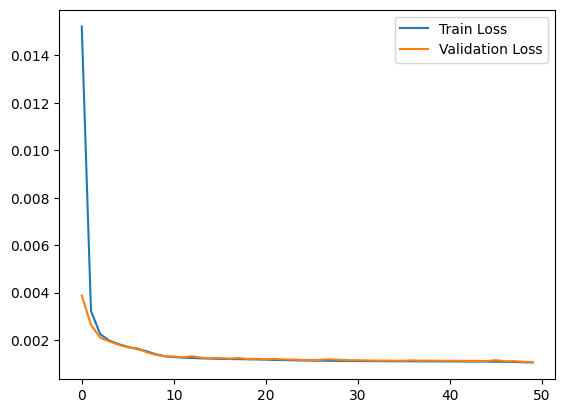

In [14]:
# Plot training loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [15]:
# Use the autoencoder to reconstruct the test data
X_test_pred = autoencoder.predict(X_test)
X_test_mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Set a threshold for classification (based on reconstruction error on normal data)
threshold = np.percentile(X_test_mse, 95)
print(f"Reconstruction error threshold: {threshold}")

# Test the model on both normal and DDoS data
X_ddos_pred = autoencoder.predict(X_ddos)
X_ddos_mse = np.mean(np.power(X_ddos - X_ddos_pred, 2), axis=1)

# Classify based on the reconstruction error
y_test_pred = X_test_mse > threshold
y_ddos_pred = X_ddos_mse > threshold

# Print results
print(f"Normal Traffic Detection Accuracy: {100 - np.mean(y_test_pred) * 100:.2f}%")
print(f"DDoS Attack Detection Accuracy: {np.mean(y_ddos_pred) * 100:.2f}%")

y_true = np.concatenate([np.zeros(len(X_test)), np.ones(len(X_ddos))])
y_pred = np.concatenate([y_test_pred, y_ddos_pred])

print(classification_report(y_true, y_pred, target_names=["BENIGN", "DDoS"]))


612/612 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Reconstruction error threshold: 0.004754539695120089
10424/10424 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
Normal Traffic Detection Accuracy: 95.00%
DDoS Attack Detection Accuracy: 100.00%
              precision    recall  f1-score   support

      BENIGN       1.00      0.95      0.97     19567
        DDoS       1.00      1.00      1.00    333540

    accuracy                           1.00    353107
   macro avg       1.00      0.97      0.99    353107
weighted avg       1.00      1.00      1.00    353107

